# KOH2: Sieć Kohonena na siatce sześciokątnej
## Laura Hoang, 313366

Do implementacji z zeszłego tygodnia dodać możliwość ułożenia neuronów w topologii siatki sześciokątnej.

Zastosować oba warianty topologii i obie funkcje sąsiedztwa do wektorów danych ze zbiorów
- MNIST
- https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

(sieć Kohonena uruchomić na zbiorach bez etykiet!).

Przeanalizować otrzymane mapowanie danych uwzględniając etykiety danych. Jak dobrze znalezione klastry odpowiadają podziałowi na klasy?

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
import math
import tensorflow as tf

## Implementacja sieci

In [2]:
class KohonenNetwork:
    def __init__(self, N, M, dataset, neurons, t=1, method='gaussian', architecture = 'rectangle'):
        '''
        N, M - wymiary siatki
        dataset - tabela danych
        neurons - wagi
        t - współczynnik wygaszania
        method - funkcja sąsiedztwa (gaussowska lub Mexican Hat)
        architecture - topologia siatki (prostokątna lub sześciokątna)
        '''

        self.N = N
        self.M = M
        self.dataset = dataset
        self.neurons = neurons
        self.t = t  # wcześniej width
        
        # if architecture == 'hexagon':
        #     self.dist = self.dist_hex
        # else:
        #     self.dist = self.dist_squ
        self.architecture = architecture
        
        if method == 'mexican':
            self.method = self.mexican_hat
        else:
            self.method = self.gauss


    def train(self, lambda_=100):
        '''
        lambda_ - liczba iteracji uczenia (liczba epoch)
        '''

        for epoch in range(lambda_):
            p = np.random.permutation(len(self.dataset))
            permuted = self.dataset[p]
            
            for x in permuted:
                minimal_pos = np.argmin([np.linalg.norm(neuron-x) for neuron in self.neurons])   # najbliższy neuron

                for i, neuron in enumerate(self.neurons):
                    if self.architecture == 'hexagon':   # siatka szesciokątna
                        # przesunięcia w siatce
                        a = (i//self.M % 2) / 2
                        b = (minimal_pos//self.M % 2) / 2
                    else:   # siatka prostokątna
                        a = 0
                        b = 0
                    self.neurons[i] = neuron + self.method(np.linalg.norm(np.array([i//self.M + a, i % self.M]) - np.array([minimal_pos//self.M + b,  minimal_pos % self.M])), self.t) * self.alpha_(epoch+1, lambda_) * (x-self.neurons[i])

    def classify(self):
        '''
        Z wykorzystaniem normy euklidesowej.
        '''
        return [np.argmin([np.linalg.norm(neuron-x) for neuron in self.neurons]) for x in self.dataset]

    # def limit_neurons(self, n):
    #     while (len(self.neurons) > n):
    #         distance = np.array([np.linalg.norm(i-j) for i in self.neurons for j in self.neurons])
    #         distance = distance[distance!=0]
    #         distance = distance.reshape(len(self.neurons),len(self.neurons)-1)
    #         index = np.unravel_index(distance.argmin(), distance.shape)[0]
    #         self.neurons = np.delete(self.neurons,index,0)


    # @staticmethod
    # def dist_rec(self, x, y):
    #     a = x%self.N - y%self.N
    #     b = math.floor(x/self.N)-math.floor(y/self.N)
        
    #     return self.width*math.sqrt(a**2 + b**2)
    
    # @staticmethod
    # def dist_hex(self, x, y):
    #     a = self.width*((x%self.N-y%self.N))
    #     b = self.width*(math.floor(x/self.N)-math.floor(y/self.N))
        
    #     if (math.floor(x/self.N)-math.floor(y/self.N))%2==0: 
    #         a += 1/2
    #     return math.sqrt(a**2 + b**2)

    @staticmethod
    def alpha_(epoch, lambda_):
        return math.exp(-epoch/lambda_)

    @staticmethod
    def gauss(x, t):
        return np.exp(-(x*t)**2)

    @staticmethod
    def mexican_hat(x, t):
        return abs((1 - 2 * (x*t)**2 ) * 2 * t**2 * np.exp(-(x*t)**2))


## Miara skuteczności

W celu oceny skuteczności modelu wykorzystana została metryka `v-measure`, określaną za pomocą wzoru:

$v = (1 + \beta) * homogeneity * completeness / (\beta * homogeneity + completeness)$, gdzie $\beta$ jest domyślnie równa 1, a *homogeneity* i *completeness* to również są metryki.

Metryka ta jest niezależna od wartości bezwzględnych etykiet: permutacja wartości etykiet klasy lub klastra nie zmieni w żaden sposób wartości wyniku.

## Zbiór danych **Human Activity Recognition Using Smartphones**

In [3]:
x = np.asarray(pd.read_csv('X_train.txt', header=None, sep='\s+'))
y = pd.read_csv('y_train.txt', header=None, sep='\s+')
y = np.array(y).reshape(-1)

print(x.shape)
print(y.shape)

(7352, 561)
(7352,)


<BarContainer object of 6 artists>

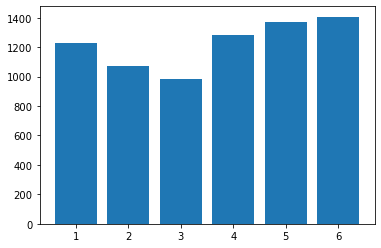

In [4]:
plt.bar(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1], width=0.8, bottom=None, align='center')

In [5]:
N, M = 2, 3
architectures = ['rectangle', 'hexagon']
methods = ['gaussian', 'mexican']

labels = []
v_measures = []
y_pred_best = y

for architecture in architectures:
    for method in methods:
        neurons = np.random.uniform(np.min(x), np.max(x), size=(N*M, x.shape[1]))
        koh = KohonenNetwork(N, M , dataset=x, neurons=neurons, method=method, architecture=architecture)
        koh.train(5)
        # print('.')

        labels += [architecture+'-'+method]
        y_pred = koh.classify()

        v_mes = metrics.v_measure_score(y, y_pred)
        if v_mes > 0 or v_mes > max(v_measures):
            y_pred_best = y_pred
        v_measures += [v_mes]


print(*labels, sep='\t')
print(*v_measures, sep='\t')


rectangle-gaussian	rectangle-mexican	hexagon-gaussian	hexagon-mexican
0.48156325749778256	0.5901690016961084	0.517057315799671	0.4313296962449964


<BarContainer object of 6 artists>

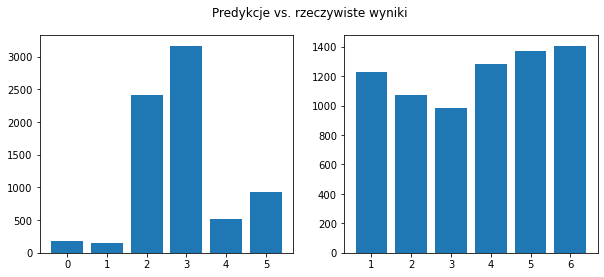

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Predykcje vs. rzeczywiste wyniki')
fig.set_size_inches(10,4)

ax1.bar(np.unique(y_pred_best, return_counts=True)[0], np.unique(y_pred_best, return_counts=True)[1], width=0.8, bottom=None, align='center')
ax2.bar(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1], width=0.8, bottom=None, align='center')

In [7]:
N, M = 4, 4
architectures = ['rectangle', 'hexagon']
methods = ['gaussian', 'mexican']

labels = []
v_measures = []
y_pred_best = y

for architecture in architectures:
    for method in methods:
        neurons = np.random.uniform(np.min(x), np.max(x), size=(N*M, x.shape[1]))
        koh = KohonenNetwork(N, M , dataset=x, neurons=neurons, method=method, architecture=architecture)
        koh.train(5)
        # print('.')

        labels += [architecture+'-'+method]
        y_pred = koh.classify()

        v_mes = metrics.v_measure_score(y, y_pred)
        if v_mes > 0 or v_mes > max(v_measures):
            y_pred_best = y_pred
        v_measures += [v_mes]


print(*labels, sep='\t')
print(*v_measures, sep='\t')


rectangle-gaussian	rectangle-mexican	hexagon-gaussian	hexagon-mexican
0.5328707592104202	0.5424323851406193	0.486148740159859	0.4608730576234831


<BarContainer object of 6 artists>

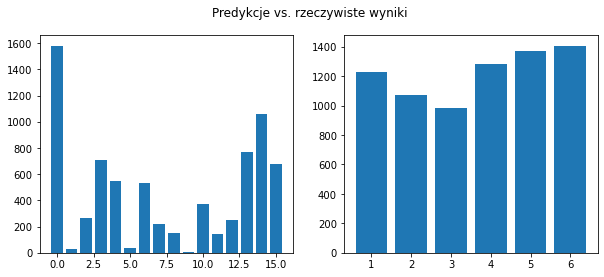

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Predykcje vs. rzeczywiste wyniki')
fig.set_size_inches(10,4)

ax1.bar(np.unique(y_pred_best, return_counts=True)[0], np.unique(y_pred_best, return_counts=True)[1], width=0.8, bottom=None, align='center')
ax2.bar(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1], width=0.8, bottom=None, align='center')

In [9]:
N, M = 6, 6
architectures = ['rectangle', 'hexagon']
methods = ['gaussian', 'mexican']

labels = []
v_measures = []
y_pred_best = y

for architecture in architectures:
    for method in methods:
        neurons = np.random.uniform(np.min(x), np.max(x), size=(N*M, x.shape[1]))
        koh = KohonenNetwork(N, M , dataset=x, neurons=neurons, method=method, architecture=architecture)
        koh.train(5)
        # print('.')

        labels += [architecture+'-'+method]
        y_pred = koh.classify()

        v_mes = metrics.v_measure_score(y, y_pred)
        if v_mes > 0 or v_mes > max(v_measures):
            y_pred_best = y_pred
        v_measures += [v_mes]


print(*labels, sep='\t')
print(*v_measures, sep='\t')

rectangle-gaussian	rectangle-mexican	hexagon-gaussian	hexagon-mexican
0.5002738903739296	0.4793037500255952	0.5078150171696526	0.4850737725523863


<BarContainer object of 6 artists>

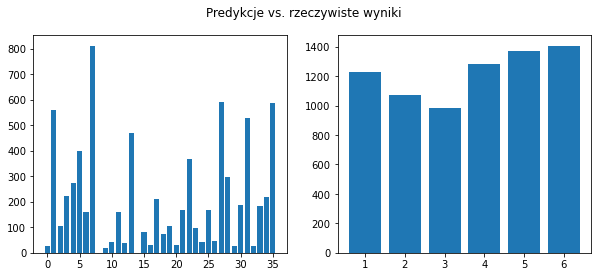

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Predykcje vs. rzeczywiste wyniki')
fig.set_size_inches(10,4)

ax1.bar(np.unique(y_pred_best, return_counts=True)[0], np.unique(y_pred_best, return_counts=True)[1], width=0.8, bottom=None, align='center')
ax2.bar(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1], width=0.8, bottom=None, align='center')

## Zbiór danych **MNIST** 

In [11]:
data = tf.keras.datasets.mnist.load_data(path='mnist.npz')

x = data[0][0]
x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])
y = data[0][1]
y = np.array(y).reshape(-1)

print(x.shape)
print(y.shape)

(60000, 784)
(60000,)


<BarContainer object of 10 artists>

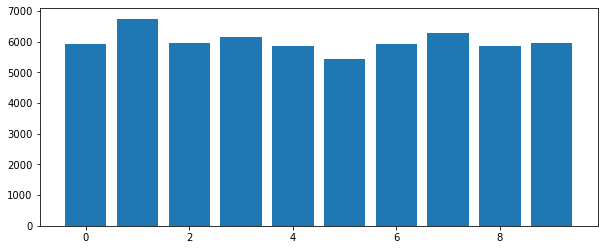

In [12]:
plt.figure(figsize=(10,4))
plt.bar(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1], width=0.8, bottom=None, align='center')

In [13]:
N, M = 3, 3
architectures = ['rectangle', 'hexagon']
methods = ['gaussian', 'mexican']

labels = []
v_measures = []
y_pred_best = y

for architecture in architectures:
    for method in methods:
        neurons = np.random.uniform(np.min(x), np.max(x), size=(N*M, x.shape[1]))
        koh = KohonenNetwork(N, M , dataset=x, neurons=neurons, method=method, architecture=architecture)
        koh.train(5)
        # print('.')

        labels += [architecture+'-'+method]
        y_pred = koh.classify()

        v_mes = metrics.v_measure_score(y, y_pred)
        if v_mes > 0 or v_mes > max(v_measures):
            y_pred_best = y_pred
        v_measures += [v_mes]


print(*labels, sep='\t')
print(*v_measures, sep='\t')


rectangle-gaussian	rectangle-mexican	hexagon-gaussian	hexagon-mexican
0.2940958880281172	0.26185864962609984	0.31929851132912485	0.2526120442050857


<BarContainer object of 10 artists>

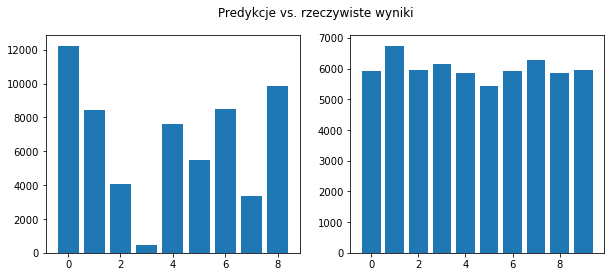

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Predykcje vs. rzeczywiste wyniki')
fig.set_size_inches(10,4)

ax1.bar(np.unique(y_pred_best, return_counts=True)[0], np.unique(y_pred_best, return_counts=True)[1], width=0.8, bottom=None, align='center')
ax2.bar(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1], width=0.8, bottom=None, align='center')

In [15]:
N, M = 4, 4
architectures = ['rectangle', 'hexagon']
methods = ['gaussian', 'mexican']

labels = []
v_measures = []
y_pred_best = y

for architecture in architectures:
    for method in methods:
        neurons = np.random.uniform(np.min(x), np.max(x), size=(N*M, x.shape[1]))
        koh = KohonenNetwork(N, M , dataset=x, neurons=neurons, method=method, architecture=architecture)
        koh.train(5)
        # print('.')

        labels += [architecture+'-'+method]
        y_pred = koh.classify()

        v_mes = metrics.v_measure_score(y, y_pred)
        if v_mes > 0 or v_mes > max(v_measures):
            y_pred_best = y_pred
        v_measures += [v_mes]


print(*labels, sep='\t')
print(*v_measures, sep='\t')


rectangle-gaussian	rectangle-mexican	hexagon-gaussian	hexagon-mexican
0.3690792040644103	0.2870764948376283	0.34806679288324427	0.2783542832968368


<BarContainer object of 10 artists>

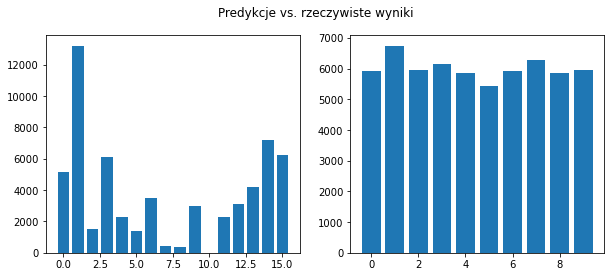

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Predykcje vs. rzeczywiste wyniki')
fig.set_size_inches(10,4)

ax1.bar(np.unique(y_pred_best, return_counts=True)[0], np.unique(y_pred_best, return_counts=True)[1], width=0.8, bottom=None, align='center')
ax2.bar(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1], width=0.8, bottom=None, align='center')

In [17]:
N, M = 6, 6
architectures = ['rectangle', 'hexagon']
methods = ['gaussian', 'mexican']

labels = []
v_measures = []
y_pred_best = y

for architecture in architectures:
    for method in methods:
        neurons = np.random.uniform(np.min(x), np.max(x), size=(N*M, x.shape[1]))
        koh = KohonenNetwork(N, M , dataset=x, neurons=neurons, method=method, architecture=architecture)
        koh.train(5)
        # print('.')

        labels += [architecture+'-'+method]
        y_pred = koh.classify()

        v_mes = metrics.v_measure_score(y, y_pred)
        if v_mes > 0 or v_mes > max(v_measures):
            y_pred_best = y_pred
        v_measures += [v_mes]


print(*labels, sep='\t')
print(*v_measures, sep='\t')

rectangle-gaussian	rectangle-mexican	hexagon-gaussian	hexagon-mexican
0.4441810353434264	0.37346908939149087	0.4315960854322604	0.3661957490569095


<BarContainer object of 10 artists>

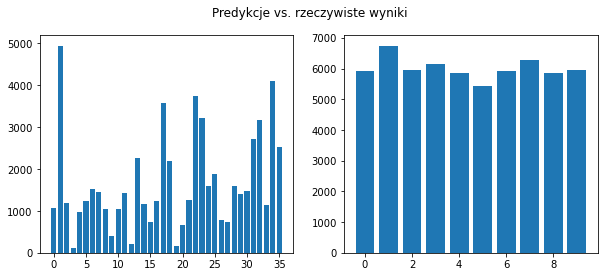

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Predykcje vs. rzeczywiste wyniki')
fig.set_size_inches(10,4)

ax1.bar(np.unique(y_pred_best, return_counts=True)[0], np.unique(y_pred_best, return_counts=True)[1], width=0.8, bottom=None, align='center')
ax2.bar(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1], width=0.8, bottom=None, align='center')